# PDF Processing with PDFExtractor

This notebook demonstrates how to use the PDFExtractor class to extract text and images from PDF files.

## 1. Setup and Configuration

In [15]:
# Import necessary libraries
import os
import sys
import logging
import tempfile
from pathlib import Path
from PIL import Image
from io import BytesIO
import base64
import json

# Add project root to path to import the Psycore modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import Psycore modules
from src.data.common_types import AttachmentTypes
from src.data.attachments import Attachment, FailedExtraction
from src.data.pdf_extractor import PDFExtractor

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("pdf_processor")

# Set up output directory
OUTPUT_DIR = os.path.join(os.getcwd(), "processed_pdfs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup completed. Output directory is:", OUTPUT_DIR)

Setup completed. Output directory is: c:\Users\Student\Documents\University\Fifth Year\COM4520\Psycore\jupyter_testing\processed_pdfs


## 2. List Available PDF Files

In [16]:
# Find all PDF files in the testing directory
PDF_DIR = os.path.join(os.getcwd(), "testing")
pdf_files = [f for f in os.listdir(PDF_DIR) if f.endswith(".pdf")]

if not pdf_files:
    print("No PDF files found in directory:", PDF_DIR)
else:
    print(f"Found {len(pdf_files)} PDF files:")
    for i, pdf_file in enumerate(pdf_files):
        file_path = os.path.join(PDF_DIR, pdf_file)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
        print(f"{i+1}. {pdf_file} ({file_size:.2f} MB)")

Found 3 PDF files:
1. 22-036458-01_GIS_early_process_evaluation_Accessible_CLIENT_USE.pdf (0.49 MB)
2. BDUK_Annual_Reports-Accounts_2024_-_Certified_copy.pdf (5.19 MB)
3. Norfolk_Public_Review_PR_RFI_Launch__Template_V2_.pdf (0.56 MB)


## 3. Define PDF Processing Function

In [17]:
def process_pdf(pdf_path, output_dir=None):
    """
    Process a PDF file using the PDFExtractor and save results.
    
    Args:
        pdf_path: Path to the PDF file
        output_dir: Directory to save processed content (optional)
    
    Returns:
        Dictionary with processing results
    """
    result = {
        "filename": os.path.basename(pdf_path),
        "success": False,
        "text_extracted": False,
        "image_count": 0,
        "error": None,
        "output_dir": None
    }
    
    try:
        # Create output directory if specified
        pdf_basename = os.path.basename(pdf_path).replace(".", "_")
        
        if output_dir:
            result_dir = os.path.join(output_dir, pdf_basename)
            os.makedirs(result_dir, exist_ok=True)
            result["output_dir"] = result_dir
        
        # Create attachment and process it
        attachment = Attachment(AttachmentTypes.FILE, pdf_path, True)
        attachment.extract()
        
        # Get extracted images
        extracted_images = attachment.pop_extra_attachments()
        result["image_count"] = len(extracted_images)
        
        # Get extracted text
        extracted_text = attachment.attachment_data
        result["text_extracted"] = len(extracted_text) > 0
        
        # Save results if output directory is specified
        if output_dir:
            # Save text content
            if result["text_extracted"]:
                text_path = os.path.join(result_dir, "extracted_text.txt")
                with open(text_path, "w", encoding="utf-8") as f:
                    f.write(extracted_text)
            
            # Save extracted images
            images_dir = os.path.join(result_dir, "images")
            os.makedirs(images_dir, exist_ok=True)
            
            for i, img in enumerate(extracted_images):
                try:
                    # Convert base64 to image
                    img_data = img.attachment_data
                    img_bytes = base64.b64decode(img_data)
                    
                    # Save the image
                    img_path = os.path.join(images_dir, f"image_{i+1}.jpg")
                    with open(img_path, "wb") as f:
                        f.write(img_bytes)
                except Exception as e:
                    logger.warning(f"Failed to save image {i+1}: {str(e)}")
            
            # Save metadata
            metadata = {
                "filename": os.path.basename(pdf_path),
                "text_length": len(extracted_text),
                "image_count": len(extracted_images),
                "processed_at": str(datetime.now())
            }
            
            metadata_path = os.path.join(result_dir, "metadata.json")
            with open(metadata_path, "w") as f:
                json.dump(metadata, f, indent=2)
        
        result["success"] = True
        
    except FailedExtraction as e:
        result["success"] = False
        result["error"] = str(e)
        logger.error(f"Failed extraction for {pdf_path}: {str(e)}")
    except Exception as e:
        result["success"] = False
        result["error"] = str(e)
        logger.error(f"Error processing {pdf_path}: {str(e)}")
    
    return result

## 4. Process a Single PDF File

In [18]:
from datetime import datetime

# Select the first PDF file for processing
if pdf_files:
    selected_pdf = pdf_files[0]
    pdf_path = os.path.join(PDF_DIR, selected_pdf)
    
    print(f"Processing PDF: {selected_pdf}")
    start_time = datetime.now()
    
    # Process the PDF
    result = process_pdf(pdf_path, OUTPUT_DIR)
    
    # Calculate processing time
    processing_time = datetime.now() - start_time
    
    # Display results
    print(f"\nProcessing completed in {processing_time.total_seconds():.2f} seconds")
    print(f"Success: {result['success']}")
    
    if result['success']:
        print(f"Extracted text: {'Yes' if result['text_extracted'] else 'No'}")
        print(f"Images extracted: {result['image_count']}")
        print(f"Results saved to: {result['output_dir']}")
    else:
        print(f"Error: {result['error']}")
else:
    print("No PDF files available for processing.")

Processing PDF: 22-036458-01_GIS_early_process_evaluation_Accessible_CLIENT_USE.pdf

Processing completed in 0.23 seconds
Success: True
Extracted text: Yes
Images extracted: 16
Results saved to: c:\Users\Student\Documents\University\Fifth Year\COM4520\Psycore\jupyter_testing\processed_pdfs\22-036458-01_GIS_early_process_evaluation_Accessible_CLIENT_USE_pdf


## 5. Display PDF Text Preview

In [19]:
# Display a preview of the extracted text
if 'result' in locals() and result['success'] and result['text_extracted']:
    text_path = os.path.join(result['output_dir'], "extracted_text.txt")
    
    if os.path.exists(text_path):
        with open(text_path, "r", encoding="utf-8") as f:
            text_content = f.read()
        
        print(f"Text Preview ({len(text_content)} characters):")
        print("="*80)
        print(text_content[:1000] + "..." if len(text_content) > 1000 else text_content)
        print("="*80)
    else:
        print("Extracted text file not found.")
elif 'result' in locals():
    print("No text was extracted from the PDF.")

Text Preview (104690 characters):
 
 
Gigabit 
Infrastructure 
Subsidy (GIS) 
Intervention 
Early process evaluation 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
22-036458-01 | Version 1 | Internal Use Only | This work was carried out in accordance with the requirements of the international quality standard for Market Research, ISO 20252 | © Ipsos 2023 
Ipsos | Gigabit Infrastructure Subsidy: Early process evaluation 
22-036458-01 | Final version | Public Use | This work was carried out in accordance with the requirements of the international quality standard for Market Research , ISO 2025 | © Ipsos 2023 
 
 
Contents 
1 Introduction ............................................................................................................................ 4 
1.1 
Description of the intervention .............................

## 6. Display Extracted Images

Found 16 extracted images:

Image 1/16:


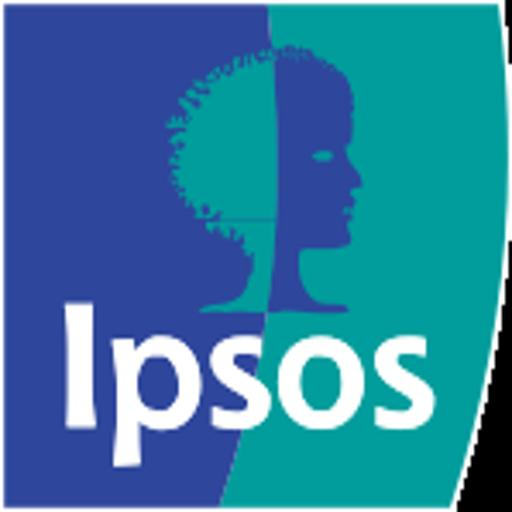


Image 2/16:


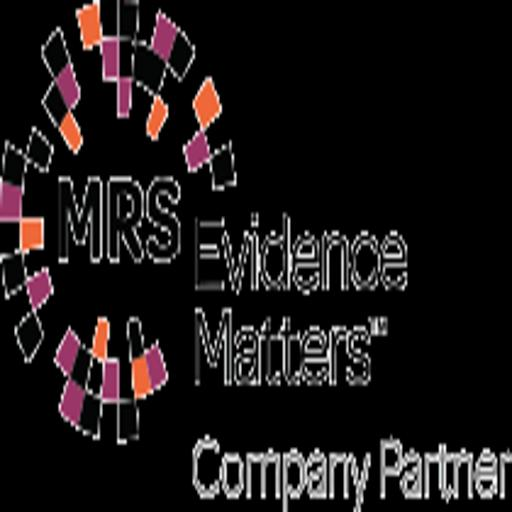


Image 3/16:


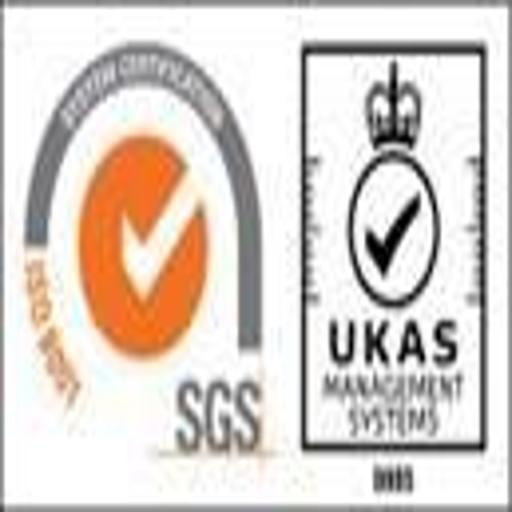


Image 4/16:


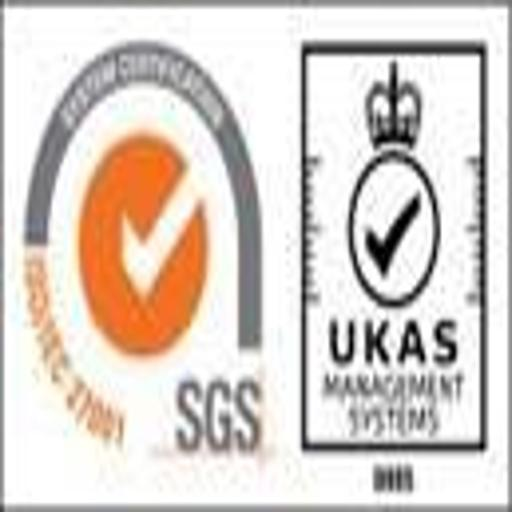


Image 5/16:


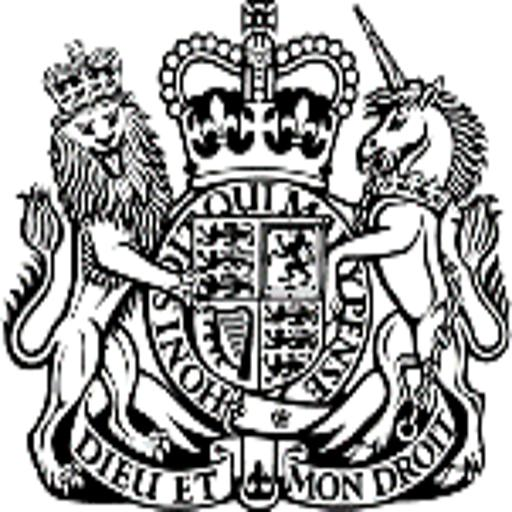


... 11 more images not displayed


In [20]:
# Display the extracted images
if 'result' in locals() and result['success'] and result['image_count'] > 0:
    from IPython.display import Image, display
    
    images_dir = os.path.join(result['output_dir'], "images")
    image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
    
    print(f"Found {len(image_files)} extracted images:")
    
    # Show first 5 images
    for i, img_file in enumerate(image_files[:5]):
        print(f"\nImage {i+1}/{len(image_files)}:")
        img_path = os.path.join(images_dir, img_file)
        display(Image(filename=img_path))
    
    if len(image_files) > 5:
        print(f"\n... {len(image_files) - 5} more images not displayed")
elif 'result' in locals() and result['success']:
    print("No images were extracted from the PDF.")

## 7. Process All PDF Files in Batch

In [ ]:
# Process all PDF files in batch
if pdf_files:
    # Create a timestamp for this batch run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    batch_dir = os.path.join(OUTPUT_DIR, f"batch_{timestamp}")
    os.makedirs(batch_dir, exist_ok=True)
    
    total_files = len(pdf_files)
    print(f"Processing {total_files} PDF files in batch...")
    
    # Process each PDF file
    results = []
    for i, pdf_file in enumerate(pdf_files, 1):
        print(f"Processing file {i}/{total_files}: {pdf_file}")
        pdf_path = os.path.join(PDF_DIR, pdf_file)
        result = process_pdf(pdf_path, batch_dir)
        results.append(result)
    
    # Summarize results
    successful = sum(1 for r in results if r["success"])
    failed = len(results) - successful
    total_images = sum(r["image_count"] for r in results if r["success"])
    
    print(f"\nBatch processing complete!")
    print(f"- Successfully processed: {successful}/{len(results)} PDFs")
    print(f"- Failed: {failed}/{len(results)} PDFs")
    print(f"- Total images extracted: {total_images}")
    print(f"- Results saved to: {batch_dir}")
    
    # Save summary report
    summary = {
        "timestamp": timestamp,
        "total_files": len(results),
        "successful": successful,
        "failed": failed,
        "total_images": total_images,
        "pdf_files": [{
            "filename": r["filename"],
            "success": r["success"],
            "text_extracted": r["text_extracted"],
            "image_count": r["image_count"],
            "error": r["error"]
        } for r in results]
    }
    
    summary_path = os.path.join(batch_dir, "summary.json")
    with open(summary_path, "w") as f:
        json.dump(summary, f, indent=2, default=str)
else:
    print("No PDF files available for batch processing.")

Processing 3 PDF files in batch...
Processing file 1/3: 22-036458-01_GIS_early_process_evaluation_Accessible_CLIENT_USE.pdf
Processing file 2/3: BDUK_Annual_Reports-Accounts_2024_-_Certified_copy.pdf
Processing file 3/3: Norfolk_Public_Review_PR_RFI_Launch__Template_V2_.pdf

Batch processing complete!
- Successfully processed: 3/3 PDFs
- Failed: 0/3 PDFs
- Total images extracted: 60
- Results saved to: c:\Users\Student\Documents\University\Fifth Year\COM4520\Psycore\jupyter_testing\processed_pdfs\batch_20250422_223156


## 8. Analyze Image Distribution

In [ ]:
# Analyze the distribution of extracted images
if 'results' in locals() and results:
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        !pip install matplotlib
        import matplotlib.pyplot as plt
    
    # Collect image counts
    successful_pdfs = [r for r in results if r["success"]]
    pdf_names = [r["filename"].split(".pdf")[0] for r in successful_pdfs]
    image_counts = [r["image_count"] for r in successful_pdfs]
    
    # Display chart
    plt.figure(figsize=(12, 6))
    plt.bar(pdf_names, image_counts)
    plt.title("Images Extracted per PDF")
    plt.xlabel("PDF File")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for i, v in enumerate(image_counts):
        plt.text(i, v + 0.5, str(v), ha='center')
    
    plt.show()
    
    # Calculate statistics
    if image_counts:
        avg_images = sum(image_counts) / len(image_counts)
        max_images = max(image_counts)
        max_pdf = pdf_names[image_counts.index(max_images)]
        
        print(f"Average images per PDF: {avg_images:.2f}")
        print(f"Maximum images in a single PDF: {max_images} (in {max_pdf})")

## 9. Search for Specific Content in Extracted Text

In [ ]:
def search_text_in_pdfs(search_term, batch_dir):
    """
    Search for a specific term in the extracted text of PDFs.
    
    Args:
        search_term: Term to search for
        batch_dir: Directory containing processed PDFs
    
    Returns:
        List of dictionaries with search results
    """
    results = []
    
    # Get all subdirectories in the batch directory
    pdf_dirs = [d for d in os.listdir(batch_dir) if os.path.isdir(os.path.join(batch_dir, d))]
    
    for pdf_dir in pdf_dirs:
        text_path = os.path.join(batch_dir, pdf_dir, "extracted_text.txt")
        
        if os.path.exists(text_path):
            with open(text_path, "r", encoding="utf-8") as f:
                text = f.read()
            
            # Search for the term
            if search_term.lower() in text.lower():
                # Find context around matches
                text_lower = text.lower()
                term_lower = search_term.lower()
                contexts = []
                
                offset = 0
                while True:
                    pos = text_lower.find(term_lower, offset)
                    if pos == -1:
                        break
                    
                    # Extract context around the match (100 chars before and after)
                    start = max(0, pos - 100)
                    end = min(len(text), pos + len(search_term) + 100)
                    context = text[start:end]
                    
                    contexts.append(context)
                    offset = pos + len(search_term)
                    
                    # Limit to 5 contexts per file
                    if len(contexts) >= 5:
                        break
                
                results.append({
                    "filename": pdf_dir,
                    "match_count": text_lower.count(term_lower),
                    "contexts": contexts
                })
    
    return results

# Allow user to search for terms in the extracted text
if 'batch_dir' in locals():
    search_term = input("Enter a term to search for in the PDF text: ")
    
    if search_term:
        print(f"Searching for '{search_term}' in processed PDFs...")
        search_results = search_text_in_pdfs(search_term, batch_dir)
        
        if search_results:
            print(f"Found '{search_term}' in {len(search_results)} PDFs:\n")
            
            for i, result in enumerate(search_results):
                print(f"{i+1}. {result['filename']} - {result['match_count']} matches")
                
                # Show the first context for each result
                if result['contexts']:
                    context = result['contexts'][0]
                    highlight = context.replace(
                        search_term, 
                        f"\033[1m\033[91m{search_term}\033[0m",
                        1
                    )
                    print(f"   Context: ...{highlight}...\n")
        else:
            print(f"No matches found for '{search_term}'")
else:
    print("No batch processing results available for searching.")

## 10. Conclusion and Next Steps

This notebook demonstrates how to use the PDFExtractor class to process PDF files and extract text and images. The extracted content can be used for a variety of applications, including:

1. **Text analysis** - Perform text mining, keyword extraction, sentiment analysis, etc.
2. **Image analysis** - Analyze extracted images for objects, faces, text, etc.
3. **Document classification** - Classify PDFs based on their content
4. **Search functionality** - Build a search index for PDF documents
5. **Data extraction** - Extract specific information from structured PDF documents

For production use, consider:
- Improving error handling and logging
- Implementing parallel processing for large batches
- Adding more advanced text and image analysis
- Integrating with a vector database for semantic search
- Creating a user interface for easier interaction